<a href="https://colab.research.google.com/github/DuncanC82/vanlife/blob/main/finaldemandakl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!curl ifconfig.me

34.74.255.18

In [ ]:
import requests
import json
import pandas as pd
import numpy as np
import holidays
import time
from datetime import datetime, timedelta
import random


# Create a date range for two years
dates = pd.date_range(start='2023-01-01', end='2024-12-31', freq='D')

# Create a DataFrame
df = pd.DataFrame(index=dates)

# Set base demand
df['demand'] = 0.5

# Increase demand on weekends
df.loc[df.index.dayofweek.isin([5, 6]), 'demand'] += 0.2

# Increase demand in summer months (Dec - Feb)
df.loc[df.index.month.isin([12, 1, 2]), 'demand'] += 0.4

# Set public holidays in New Zealand for both 2023 and 2024
nz_holidays = holidays.NewZealand(years=[2023, 2024])

# Increase demand on holidays
df.loc[df.index.isin(nz_holidays), 'demand'] += 0.3

# Increase demand during Farmers Santa Parade (assumed to be on the same day in 2024)
santa_parade_dates = [pd.to_datetime('2023-11-26'), pd.to_datetime('2024-11-24')]
df.loc[df.index.isin(santa_parade_dates), 'demand'] += 0.5

# Increase demand during Christmas Lights at MOTAT (assumed to be in December until Christmas Eve for both years)
motat_start_dates = [pd.to_datetime('2023-12-01'), pd.to_datetime('2024-12-01')]
motat_end_dates = [pd.to_datetime('2023-12-24'), pd.to_datetime('2024-12-24')]
for start_date, end_date in zip(motat_start_dates, motat_end_dates):
    df.loc[(df.index >= start_date) & (df.index <= end_date), 'demand'] += 0.2

# Cap the demand at 1.0
df['demand'] = df['demand'].clip(upper=1.0)

# Fetch weather data for Auckland
latitude = -36.875
longitude = 174.75
hourly_parameters = ['precipitation']
url = "https://api.open-meteo.com/v1/forecast"
params = {
    "latitude": latitude,
    "longitude": longitude,
    "hourly": hourly_parameters,
    "forecast_days": 7,
    "timezone": "Pacific/Auckland",
}
response = requests.get(url, params=params)

# Only apply weather effect for the next 7 days
forecast_end = min(df.index.max(), pd.Timestamp(datetime.today().date() + timedelta(days=7)))

if response.status_code == 200:
    weather_data = json.loads(response.text)
    hourly_data = weather_data.get("hourly", {}).get("precipitation", [])
    for date, precipitation in zip(df.loc[:forecast_end].index, hourly_data):
        date_str = date.strftime("%Y-%m-%d")
        precipitation_value = precipitation if isinstance(precipitation, (int, float)) else 0
        # Decrease demand on days with heavy rain or snow (assuming precipitation > 10 is heavy rain/snow)
        if precipitation_value > 10:
            df.loc[date_str, 'demand'] *= 0.8
else:
    print(f"Request failed with status code {response.status_code}")

# Normalize demand to range 0-1
df['demand'] = (df['demand'] - df['demand'].min()) / (df['demand'].max() - df['demand'].min())

# Define the base URL for the hotel pricing API
base_url = "https://www.agoda.com/api/personalization/PersonalizeRecommendedProperties/v1"

# Initialize an empty list to store the results
data_list = []

# Calculate the dates for the next year
today = datetime.today()
dates = [today + timedelta(days=i) for i in range(365) if (today + timedelta(days=i)).weekday() in [2, 4]]

# Define the maximum number of retries
max_retries = 5

# Loop over the dates
for date in dates:
    retry_count = 0  # Initialize the retry count
    while retry_count < max_retries:
        # Define the parameters for the API request
        params = {
            "finalPriceView": 2,
            "hotelId": 2962035,
            "hasSearchCriteria": True,
            "checkIn": date.strftime("%Y-%m-%dT00:00:00"),
            "lengthOfStay": 3,
            "adults": 1,
            "children": 0,
            "rooms": 1,
            "loyaltyProgramId": 0,
            "size": None,
            "recommendationType": 1,
            "cityId": 3750,
            "_ts": int(time.time() * 1000)
        }

        # Make the API request
        response = requests.get(base_url, params=params)

        # Check if the request was successful
        if response.status_code == 200:
            # Convert the response to JSON
            data = response.json()

            # Check if the response has data
            if "PersonalizedRecommendedProperties" in data:
                for hotel in data["PersonalizedRecommendedProperties"]:
                    hotel['check_in_date'] = date.date()  # Add the check-in date to the hotel data
                    data_list.append(hotel)
                break  # Break out of the retry loop if data is found

        # Increment the retry count and wait for a random time before retrying
        retry_count += 1
        sleep_time = random.uniform(3, 9)
        time.sleep(sleep_time)

    if retry_count == max_retries:
        print(f"Failed to fetch data for {date}. Moving on to the next date.")

# Convert the list to a DataFrame
df_hotel = pd.DataFrame(data_list)
# df_hotel['StarRating'] = df_hotel['StarRating'].apply(lambda x: int(x.split('-')[-1]) if x and x.split('-')[-1].isdigit() else np.nan)

# # Preprocess the hotel DataFrame
# df_hotel['check_in_date'] = pd.to_datetime(df_hotel['check_in_date'])
# df_hotel['StarRating'] = df_hotel['StarRating'].apply(lambda x: int(x.split('-')[-1]))

# # Group the hotel DataFrame by 'StarRating' and 'check_in_date' and calculate the average price
# grouped_df = df_hotel.groupby(['StarRating', pd.Grouper(key='check_in_date', freq='D')])['Price'].mean()

# # Split the grouped_df into separate dataframes based on 'StarRating'
# dfs = {star_rating: grouped_df.xs(star_rating).reset_index() for star_rating in grouped_df.index.levels[0]}

# # Incorporate the daily average prices into the demand forecast
# for star_rating, hotel_df in dfs.items():
#     # Merge the demand DataFrame with the hotel price DataFrame
#     df = pd.merge(df, hotel_df, left_index=True, right_on='check_in_date', how='left')
#     # Rename the new column
#     df.rename(columns={'Price': f'avg_price_{star_rating}'}, inplace=True)

#     # Forward fillf'avg_price_{star_rating}'] = df.loc[mask, f'avg_price_{star_rating}'].ffill()

# # Now df is your demand DataFrame with added columns for the average hotel price for each star rating

In [ ]:
df_hotel_sorted = df_hotel.sort_values(by='Price', ascending=False)


In [ ]:
df_hotel

,PropertyId,IsFavorite,HotelName,ImageUrl,StarRating,ReviewCount,ReviewScoreText,ReviewScore,Price,Currency,...,Latitude,Longitude,SupplierId,TopValueForMoney,BestSellerText,Engagement,Features,MatchScore,FilteredBy,check_in_date
0,2962035,False,No. 9 Hotel,//pix6.agoda.net/hotelImages/2962035/-1/f19ecf...,star-3,330,Very good,7.8,35.62,$,...,0,0,0,None,Best seller,None,None,None,None,2023-07-12
1,69665,False,Kiwi International Hotel,//pix6.agoda.net/hotelImages/69665/-1/5c0df9f4...,star-3,2243,Very good,7.7,62.81,$,...,0,0,0,None,Best seller,None,None,None,None,2023-07-12
2,161826,False,Fort Street,//pix6.agoda.net/hotelImages/161826/-1/bda8040...,star-3,445,Good,6.8,47.26,$,...,0,0,0,None,None,None,None,None,None,2023-07-12
3,295359,False,YMCA Hostel,//pix6.agoda.net/hotelImages/295359/-1/af6c40e...,star-45,875,Excellent,8.1,26.49,$,...,0,0,0,None,None,None,None,None,None,2023-07-12
4,299940,False,Surf 'n' Snow Backpackers,//pix6.agoda.net/hotelImages/299/299940/299940...,star-4,2073,Good,6.3,15.24,$,...,0,0,0,None,None,None,None,None,None,2023-07-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004,186130,False,City Lodge Accommodation,//pix6.agoda.net/hotelImages/186/186130/186130...,star-5,672,Excellent,8.2,89.55,$,...,0,0,0,None,None,None,None,None,None,2024-07-03
1005,108737,False,President Hotel Auckland,//pix6.agoda.net/hotelImages/108737/-1/68d02bd...,star-35,1577,Excellent,8.1,311.54,$,...,0,0,0,None,None,None,None,None,None,2024-07-03
1006,2962035,False,No. 9 Hotel,//pix6.agoda.net/hotelImages/2962035/-1/f19ecf...,star-3,330,Very good,7.8,37.31,$,...,0,0,0,None,Best seller,None,None,None,None,2024-07-05
1007,295359,False,YMCA Hostel,//pix6.agoda.net/hotelImages/295359/-1/af6c40e...,star-45,875,Excellent,8.1,49.13,$,...,0,0,0,None,Best seller,None,None,None,None,2024-07-05


In [ ]:
df_hotel['StarRating'] = df_hotel['StarRating'].apply(lambda x: int(x.split('-')[-1]) if x and x.split('-')[-1].isdigit() else np.nan)

In [ ]:

# Preprocess the StarRating column
df_hotel['StarRating'] = df_hotel['StarRating'].apply(
    lambda x: int(x.split('-')[-1]) if isinstance(x, str) and x.split('-')[-1].isdigit() else (int(x) if not np.isnan(x) else np.nan)
)

# Preprocess the check_in_date column
df_hotel['check_in_date'] = pd.to_datetime(df_hotel['check_in_date'])

# Group the hotel DataFrame by 'StarRating' and 'check_in_date' and calculate the average price
grouped_df = df_hotel.groupby(['StarRating', pd.Grouper(key='check_in_date', freq='D')])['Price'].mean()

# Split the grouped_df into separate dataframes based on 'StarRating'
dfs = {
    star_rating: grouped_df.xs(star_rating).reset_index().rename(columns={'check_in_date': 'check_in_date'})
    for star_rating in grouped_df.index.levels[0]
}

# Drop any existing 'avg_price' columns
df = df.loc[:, ~df.columns.str.startswith('avg_price')]

# Reset the index and rename the column to 'check_in_date'
df.reset_index(inplace=True)
df.rename(columns={'index': 'check_in_date'}, inplace=True)


# Incorporate the daily average prices into the demand forecast
for star_rating, hotel_df in dfs.items():
    # Merge the demand DataFrame with the hotel price DataFrame
    df = pd.merge(df, hotel_df, on='check_in_date', how='left')
    # Rename the new column
    df.rename(columns={'Price': f'avg_price_{star_rating}'}, inplace=True)

    # Forward fill NaN values for dates from today onwards
    mask = df['check_in_date'] >= pd.Timestamp(today.date())
    df.loc[mask, f'avg_price_{star_rating}'] = df.loc[mask, f'avg_price_{star_rating}'].ffill()

In [ ]:
df

,check_in_date,demand,avg_price_3.0,avg_price_4.0,avg_price_5.0,avg_price_35.0,avg_price_45.0
0,2023-01-01,1.0,NaN,NaN,NaN,NaN,NaN
1,2023-01-02,1.0,NaN,NaN,NaN,NaN,NaN
2,2023-01-03,1.0,NaN,NaN,NaN,NaN,NaN
3,2023-01-04,0.8,NaN,NaN,NaN,NaN,NaN
4,2023-01-05,0.8,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
726,2024-12-27,0.8,36.91,8.27,75.67,89.625,48.6
727,2024-12-28,1.0,36.91,8.27,75.67,89.625,48.6
728,2024-12-29,1.0,36.91,8.27,75.67,89.625,48.6
729,2024-12-30,0.8,36.91,8.27,75.67,89.625,48.6


In [ ]:
df_hotel

,PropertyId,IsFavorite,HotelName,ImageUrl,StarRating,ReviewCount,ReviewScoreText,ReviewScore,Price,Currency,...,Latitude,Longitude,SupplierId,TopValueForMoney,BestSellerText,Engagement,Features,MatchScore,FilteredBy,check_in_date
0,2962035,False,No. 9 Hotel,//pix6.agoda.net/hotelImages/2962035/-1/f19ecf...,3.0,330,Very good,7.8,91.25,$,...,0,0,0,None,Best seller,None,None,None,None,2023-07-12
1,69665,False,Kiwi International Hotel,//pix6.agoda.net/hotelImages/69665/-1/5c0df9f4...,3.0,2243,Very good,7.7,62.13,$,...,0,0,0,None,Best seller,None,None,None,None,2023-07-12
2,161826,False,Fort Street,//pix6.agoda.net/hotelImages/161826/-1/bda8040...,3.0,445,Good,6.8,45.41,$,...,0,0,0,None,None,None,None,None,None,2023-07-12
3,295359,False,YMCA Hostel,//pix6.agoda.net/hotelImages/295359/-1/af6c40e...,45.0,875,Excellent,8.1,26.21,$,...,0,0,0,None,None,None,None,None,None,2023-07-12
4,408659,False,Ascotia Off Queen,//pix6.agoda.net/hotelImages/408/408659/408659...,35.0,1225,Very good,7.3,73.92,$,...,0,0,0,None,None,None,None,None,None,2023-07-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,408659,False,Ascotia Off Queen,//pix6.agoda.net/hotelImages/408/408659/408659...,35.0,1225,Very good,7.3,79.36,$,...,0,0,0,None,None,None,None,None,None,2024-06-28
997,186130,False,City Lodge Accommodation,//pix6.agoda.net/hotelImages/186/186130/186130...,5.0,672,Excellent,8.2,75.67,$,...,0,0,0,None,None,None,None,None,None,2024-06-28
998,108737,False,President Hotel Auckland,//pix6.agoda.net/hotelImages/108737/-1/68d02bd...,35.0,1575,Excellent,8.1,99.89,$,...,0,0,0,None,None,None,None,None,None,2024-06-28
999,2962035,False,No. 9 Hotel,//pix6.agoda.net/hotelImages/2962035/-1/f19ecf...,3.0,330,Very good,7.8,36.91,$,...,0,0,0,None,None,None,None,None,None,2024-07-03


In [ ]:
# Import necessary libraries
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the demand
df['demand_normalized'] = scaler.fit_transform(df[['demand']])

# Normalize the average prices
for col in df.columns:
    if 'avg_price' in col:
        df[col] = scaler.fit_transform(df[[col]])

# Define the weights for each average price
weights = {'avg_price_3.0': 2, 'avg_price_4.0': 1, 'avg_price_5.0': 1, 'avg_price_35.0': 1, 'avg_price_45.0': 1}  # Adjust as needed

# Calculate the weighted sum of the average prices
df['weighted_sum'] = sum(df[col] * weight for col, weight in weights.items())

# Define the weight of the demand
weight_of_demand = 1  # Adjust as needed

# Calculate the final demand
df['final_demand'] = df['demand_normalized'] * weight_of_demand + df['weighted_sum']

In [ ]:
# Calculate the final demand
df['final_demand'] = df['demand_normalized'] * weight_of_demand + df['weighted_sum']

# Set NaN values in final_demand to original demand
df['final_demand'].fillna(df['demand'], inplace=True)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the final demand
df['final_demand_normalized'] = scaler.fit_transform(df[['final_demand']])

In [ ]:
df

,check_in_date,demand,avg_price_3.0,avg_price_4.0,avg_price_5.0,avg_price_35.0,avg_price_45.0,demand_normalized,weighted_sum,final_demand,final_demand_normalized
0,2023-01-01,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.000000,0.238144
1,2023-01-02,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.000000,0.238144
2,2023-01-03,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.000000,0.238144
3,2023-01-04,0.8,NaN,NaN,NaN,NaN,NaN,0.8,NaN,0.800000,0.190515
4,2023-01-05,0.8,NaN,NaN,NaN,NaN,NaN,0.8,NaN,0.800000,0.190515
...,...,...,...,...,...,...,...,...,...,...,...
726,2024-12-27,0.8,0.024349,0.0,0.438961,1.0,0.493246,0.8,1.980905,2.780905,0.662256
727,2024-12-28,1.0,0.024349,0.0,0.438961,1.0,0.493246,1.0,1.980905,2.980905,0.709885
728,2024-12-29,1.0,0.024349,0.0,0.438961,1.0,0.493246,1.0,1.980905,2.980905,0.709885
729,2024-12-30,0.8,0.024349,0.0,0.438961,1.0,0.493246,0.8,1.980905,2.780905,0.662256


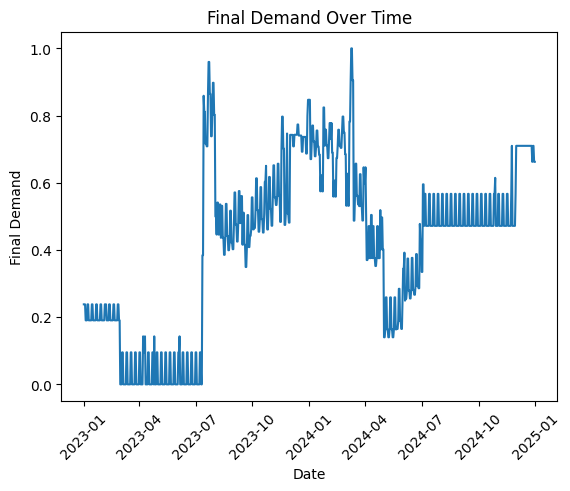

In [ ]:
import matplotlib.pyplot as plt

# Plot the final_demand
plt.plot(df['check_in_date'], df['final_demand_normalized'])
plt.xlabel('Date')
plt.ylabel('Final Demand')
plt.title('Final Demand Over Time')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Import necessary libraries
from google.colab import drive
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore

# Mount Google Drive
drive.mount('/content/drive')

# Path to the service account key file in Google Drive
key_path = '/content/drive/MyDrive/Firebase/supple-comfort-353123-firebase-adminsdk-67xac-2f7ad853e1.json'

# Check if the default Firebase app has already been initialized
if not firebase_admin._apps:
    # Initialize Firebase Admin SDK with the service account key file
    cred = credentials.Certificate(key_path)
    firebase_admin.initialize_app(cred)

# Access Firestore database
db = firestore.client()

# Define the collection and subcollection names
collection_name = 'Demand'
subcollection_name = 'Auckland'


# Convert today to a Timestamp object
today = pd.Timestamp(today.date())


# Loop over the demand data and update Firestore
for check_in_date, final_demand, final_demand_normalized in zip(df['check_in_date'], df['final_demand'], df['final_demand_normalized']):
    # # Check if check_in_date is after today
    if check_in_date > today:
        # Convert check_in_date to string
        check_in_date_str = check_in_date.strftime('%Y-%m-%d')

        # Create a document reference for the check_in_date
        doc_ref = db.collection(collection_name).document(subcollection_name).collection('FinalDemand').document(check_in_date_str)

        # Calculate the lead time in days
        lead_time = (check_in_date - today).days

        # Create a dictionary of data to be stored in the document
        data = {
            'LeadTime': firestore.ArrayUnion([lead_time]),
            'FinalDemand': firestore.ArrayUnion([final_demand]),
            'FinalDemandNormalized': firestore.ArrayUnion([final_demand_normalized]),
            'check_in_date': firestore.ArrayUnion([check_in_date])
        }

        # Update the document in Firestore using array union
        doc_ref.set(data, merge=True)


print('Data has been successfully updated in Firestore.')







Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data has been successfully updated in Firestore.
